# Proyecto 03
## Visión Por Computadora

In [44]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [45]:
images_dir = 'imagenes/'
input_dir = 'input0'

In [46]:
# fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# image_1 = cv2.imread(os.path.join(images_dir, input_dir, 's22.png'))
# ax[0].imshow(cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB))
# ax[0].set_title('Original Image')
# ax[0].axis('off')

# image_2 = cv2.imread(os.path.join(images_dir, input_dir, 's11.png'))
# ax[1].imshow(cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB))
# ax[1].set_title('Original Image')
# ax[1].axis('off')


### 2

In [47]:
def find_homography(image_1_data, image_2_data):
    sift = cv2.xfeatures2d.SIFT_create()

    keypoints_1, descriptors_1 = sift.detectAndCompute(image_1_data, None)
    keypoints_2, descriptors_2 = sift.detectAndCompute(image_2_data, None)

    brute_force_matcher = cv2.BFMatcher()
    matches = brute_force_matcher.knnMatch(descriptors_1, descriptors_2, k=2)
    good_matches = np.asarray([m for m in matches if m[0].distance < 0.7 * m[1].distance])

    MIN_MATCH_COUNT = 10
    if len(good_matches) > MIN_MATCH_COUNT:
        src_pts = np.float32([keypoints_1[m.queryIdx].pt for m in good_matches[:, 0]]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints_2[m.trainIdx].pt for m in good_matches[:, 0]]).reshape(-1, 1, 2)

        H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        return H

    else:
        print(f"Not enough matches - {len(good_matches)/MIN_MATCH_COUNT}")


### 3

In [48]:
def warping(img1, img2, homography):
    height_img1, width_img1, _ = img1.shape
    height_img2, width_img2, _ = img2.shape

    img1_warped = cv2.warpPerspective(img1, homography, (width_img1 + width_img2, height_img2))
    img1_warped[0:height_img2, 0:width_img2] = img2

    return img1_warped

In [49]:
# homography_12 = find_homography(image_1, image_2)
# warped_img = warping(image_1, image_2, homography_12)

# plt.figure(figsize=(20,10))
# plt.imshow(warped_img)
# plt.show()

In [50]:
# # Carga las imágenes
# images_dir = "imagenes\input0"  # Asegúrate de definir esta variable correctamente
# image_files = ['a3.png','a2.png' ,'a1.png']
# images = [cv2.imread(os.path.join(images_dir, f)) for f in image_files if f]

# # Calcula las homografías y crea la imagen panorámica
# previous_image = images[0]
# for i in range(1, len(images)):
#     H = find_homography(previous_image, images[i])
#     if H is not None:
#         previous_image = warping(previous_image, images[i], H)

# # Visualiza el resultado
# plt.figure(figsize=(15, 10))
# plt.imshow(cv2.cvtColor(previous_image, cv2.COLOR_BGR2RGB))
# plt.title("Panoramic Image")
# plt.axis('off')
# plt.show()


## WARPING WITH BLENDING (DEGRADADO ENTRE IMAGENES)

In [51]:
def warping(img1, img2, homography):
    height_img1, width_img1 = img1.shape[:2]
    height_img2, width_img2 = img2.shape[:2]

    corners_img2 = np.float32([[0, 0], # top-left 
                               [0, height_img2], # bottom-left
                               [width_img2, height_img2], # bottom-right
                               [width_img2, 0]]).reshape(-1,1,2) # top-right
    corners_img2 = cv2.perspectiveTransform(corners_img2, homography)

    [x_min, _] = np.int32(corners_img2.min(axis=0).ravel())
    [x_max, y_max] = np.int32(corners_img2.max(axis=0).ravel())

    x_min = min(0, x_min)
    x_max = max(width_img1, x_max)

    # Calcular dimensiones de la imagen de salida
    output_width = x_max - x_min
    output_height = max(height_img1, y_max)

    # Warp img1 con la homografía
    img1_warped = cv2.warpPerspective(img1, homography, (output_width, output_height))

    
    mask1_warped = cv2.warpPerspective(np.ones((height_img1, width_img1), dtype=np.uint8), homography, (output_width, output_height))

    # Preparar el canvas para el resultado final
    result = np.zeros((output_height, output_width, 3), dtype=img1.dtype)
    
    # Preparar la imagen y máscara de img2 en el canvas extendido
    img2_extended = np.zeros((output_height, output_width, 3), dtype=img2.dtype)
    img2_extended[:height_img2, :width_img2] = img2
    mask2_extended = np.zeros((output_height, output_width), dtype=np.uint8)
    mask2_extended[:height_img2, :width_img2] = 1

    # Identificar áreas de superposición y no superposición
    overlap = (mask1_warped == 1) & (mask2_extended == 1)
    non_overlap1 = (mask1_warped == 1) & (mask2_extended == 0)
    non_overlap2 = (mask1_warped == 0) & (mask2_extended == 1)

    if np.any(overlap):
        rows, cols = np.where(overlap)
        min_col, max_col = cols.min(), cols.max()
        gradient_width = max_col - min_col + 1
        alpha = np.linspace(1, 0, gradient_width)  # Invertir la dirección del degradado

        # Crear una máscara de degradado completa para la región de superposición
        full_alpha = np.zeros_like(img1_warped[:, :, 0], dtype=float)
        full_alpha[:, min_col:max_col+1] = alpha

        # Usar la máscara de degradado para el blending
        for c in range(3):  # Repetir para cada canal de color
            result[overlap, c] = (img1_warped[overlap, c] * (1 - full_alpha[overlap]) + img2_extended[overlap, c] * full_alpha[overlap]).astype(np.uint8)
    
    # Donde solo img1 tiene datos
    result[non_overlap1] = img1_warped[non_overlap1]
    
    # Donde solo img2 tiene datos
    result[non_overlap2] = img2_extended[non_overlap2]

    return result


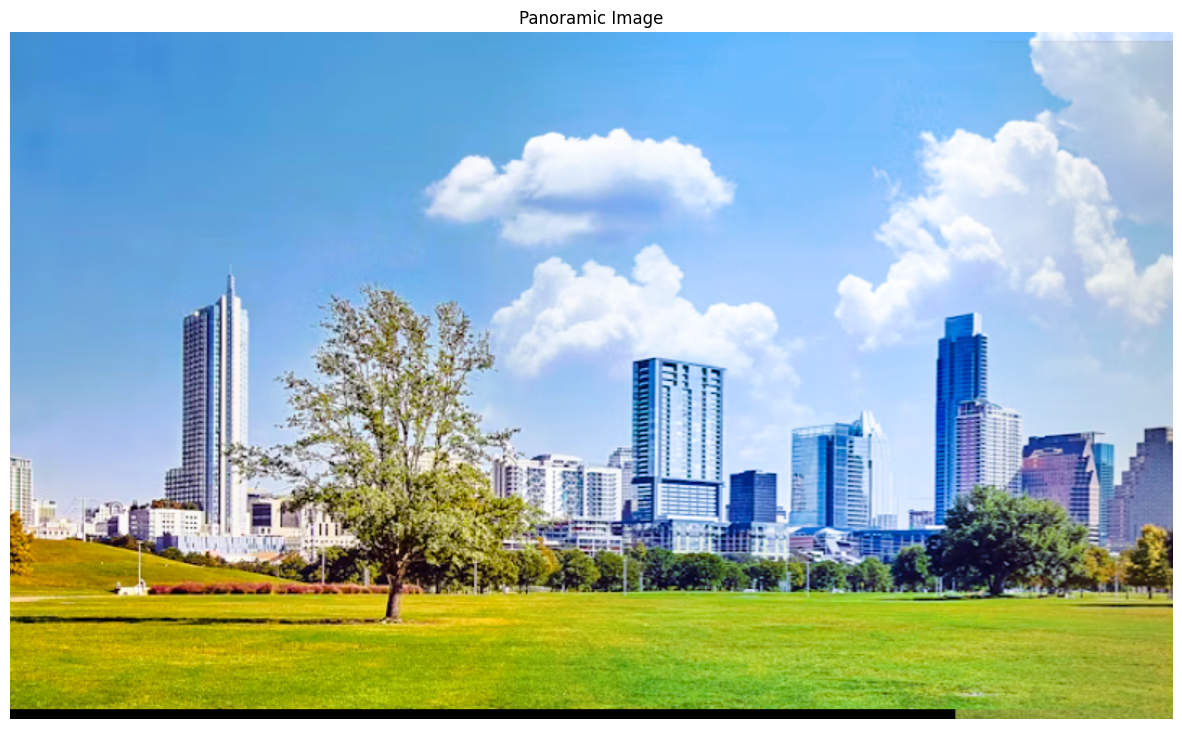

In [52]:
# Carga las imágenes
images_dir = "imagenes/input0"
image_files = ['a3.png', 'a2.png', 'a1.png']
images = [cv2.imread(os.path.join(images_dir, f)) for f in image_files if f]

# Calcula las homografías y crea la imagen panorámica
previous_image = images[0]
for i in range(1, len(images)):
    H = find_homography(previous_image, images[i])
    if H is not None:
        previous_image = warping(previous_image, images[i], H)

# Visualiza el resultado
plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(previous_image, cv2.COLOR_BGR2RGB))
plt.title("Panoramic Image")
plt.axis('off')
plt.show()
